In [1]:
# local install includes
local_venv = '/udd0/litterbox/venv/bin/activate_this.py'
execfile(local_venv, dict(__file__=local_venv))

%matplotlib inline
import numpy as np
from astropy import units as u
import astropy.coordinates as coords

In [2]:
RA = '15h11m41.299s'
DEC = '-06d00m41.462'
parallax = 2.06  # mas
proper_motion = (-10.153, -15.020)  # mas/yr
radial_velocity = 14.  # vlsr km/s

In [3]:
parallax = parallax*u.mas # mas = milli-arcseconds
distance = (parallax).to(u.kpc, u.parallax())

print 'Annual parallax is {}, corresponding to a distance of {}'.format(
      parallax,
      distance)


target = coords.ICRS(RA, DEC,
                     distance=distance,
                     pm_ra_cosdec=proper_motion[0]*(u.mas/u.yr),
                     pm_dec=proper_motion[1]*(u.mas/u.yr),
                     radial_velocity=radial_velocity*(u.km/u.s))
print target
target_galactic = target.transform_to(coords.Galactic)
print target_galactic
target_galactocentric = target.transform_to(coords.Galactocentric)
print target_galactocentric

Annual parallax is 2.06 mas, corresponding to a distance of 0.485436893204 kpc
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (227.92207917, -6.01151722, 0.48543689)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-10.153, -15.02, 14.)>
<Galactic Coordinate: (l, b, distance) in (deg, deg, kpc)
    (353.82613007, 42.58762167, 0.48543689)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-17.73605514, -3.75714745, 14.)>
<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (-7.94356306, -0.0384377, 0.3543462)
 (v_x, v_y, v_z) in km / s
    (22.78515192, 189.92474948, 10.32047677)>


In [4]:
target_gal = target.transform_to(coords.Galactic)
target_gal.representation = 'cartesian'
print target_gal

<Galactic Coordinate: (u, v, w) in kpc
    (0.35532678, -0.03843689, 0.32850336)
 (U, V, W) in km / s
    (11.6751456, -42.31523509, 3.10851791)>


In [5]:
import matplotlib.pylab as plt
from galpy.orbit import Orbit
import galpy

In [6]:
MWPotential2014=galpy.potential.MWPotential2014
ts = np.linspace(0,1.,10000)*u.Gyr
ts_long = np.linspace(0,10.,10000)*u.Gyr

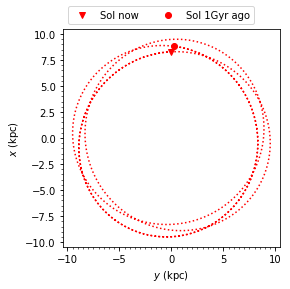

In [7]:
Sol = coords.Galactocentric()
Sol_orbit = Orbit(vxvv=[Sol.galcen_distance,
                        Sol.galcen_v_sun.d_x,
                        Sol.galcen_v_sun.d_y,
                        Sol.z_sun,
                        Sol.galcen_v_sun.d_z,
                        0.*u.deg])
Sol_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration
Sol_orbit.integrate(ts, MWPotential2014, method='rk4_c')
Sol_orbit.plot(d1='y', d2='x', color='r', linestyle=':')
plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'rv', label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'ro', label='Sol 1Gyr ago')
plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

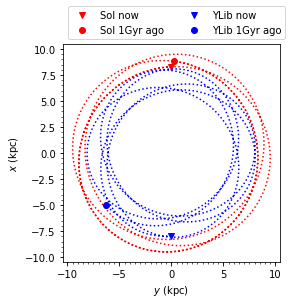

In [8]:
Sol = coords.Galactocentric()
Sol_orbit = Orbit(vxvv=[Sol.galcen_distance,
                        Sol.galcen_v_sun.d_x,
                        Sol.galcen_v_sun.d_y,
                        Sol.z_sun,
                        Sol.galcen_v_sun.d_z,
                        0.*u.deg])
Sol_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration
Sol_orbit.integrate(ts, MWPotential2014, method='rk4_c')

xyztgt_orbit = Orbit(vxvv=[target_galactocentric.x,
                           target_galactocentric.v_x,
                           target_galactocentric.v_y,
                           target_galactocentric.z,
                           target_galactocentric.v_z,
                        0.*u.deg])
xyztgt_orbit.flip(inplace=True)
xyztgt_orbit.integrate(ts, MWPotential2014, method='rk4_c')


Sol_orbit.plot(d1='y', d2='x', color='r', linestyle=':')
plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'rv', label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'ro', label='Sol 1Gyr ago')

xyztgt_orbit.plot(d1='y', d2='x', color='b', linestyle=':', overplot=True)
plt.plot(xyztgt_orbit.y(ts)[0], xyztgt_orbit.x(ts)[0], 'bv', label='YLib now')
plt.plot(xyztgt_orbit.y(ts)[-1], xyztgt_orbit.x(ts)[-1], 'bo', label='YLib 1Gyr ago')

plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);
plt.savefig('YLib_VERA_near_xz.png', type="png", dpi=300)

(-8.814037486793707, 8.861583688980359, -8.87611919172615, 8.799501984047915)

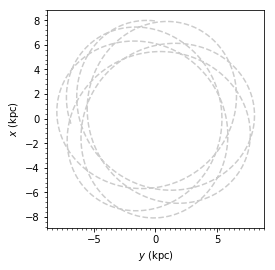

In [9]:
target_orbit= Orbit(vxvv=[target_galactic.l,
                          target_galactic.b,
                          target_galactic.distance,
                          target_gal.U,
                          target_gal.V,
                          target_gal.W],
                    solarmotion='dehnen',
                    lb=True, uvw=True,
                    ro=Sol.galcen_distance,
                    vo=(Sol.galcen_v_sun.d_y - target.transform_to(coords.LSR).v_bary.d_y))
target_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration
target_orbit.integrate(ts, MWPotential2014, method='rk4_c')
target_orbit.plot(d1='y', d2='x', color='k', alpha=0.2, linestyle='--')
plt.axis('square')

Dispersion of rotational distance -0.270168250265 +- [4.90289244053] kpc


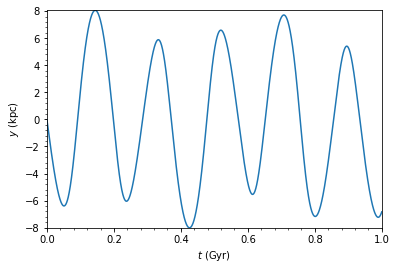

In [10]:
target_orbit.ploty()
print 'Dispersion of rotational distance {} +- [{}] kpc'.format(
      np.mean(target_orbit.y(ts)),
      np.std(target_orbit.y(ts)))
plt.savefig('YLib_VERA_near_Y.png', type="png", dpi=300)

Dispersion of rotational distance 0.227386488079 +- [4.9350293982] kpc


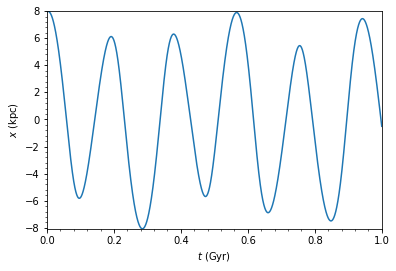

In [11]:
target_orbit.plotx()
print 'Dispersion of rotational distance {} +- [{}] kpc'.format(
      np.mean(target_orbit.x(ts)),
      np.std(target_orbit.x(ts)))
plt.savefig('YLib_VERA_near_X.png', type="png", dpi=300)

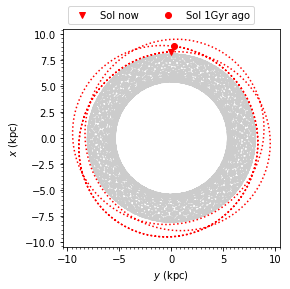

In [12]:
target_orbit.integrate(ts_long, MWPotential2014, method='rk4_c')
target_orbit.plot(d1='y', d2='x', color='k', alpha=0.2, linestyle='--')

Sol_orbit.plot(d1='y', d2='x', color='r', linestyle=':', overplot=True)
plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'rv', label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'ro', label='Sol 1Gyr ago')
plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

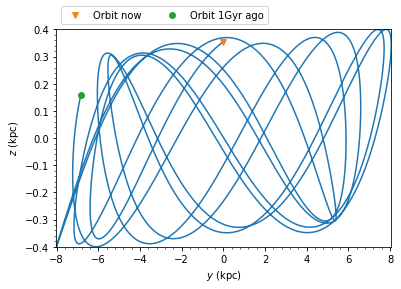

In [13]:
target_orbit.integrate(ts, MWPotential2014, method='rk4_c')
target_orbit.plot(d1='y', d2='z')
plt.plot(target_orbit.y(ts)[0], target_orbit.z(ts)[0], 'v', label='Orbit now')
plt.plot(target_orbit.y(ts)[-1], target_orbit.z(ts)[-1], 'o', label='Orbit 1Gyr ago')

plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

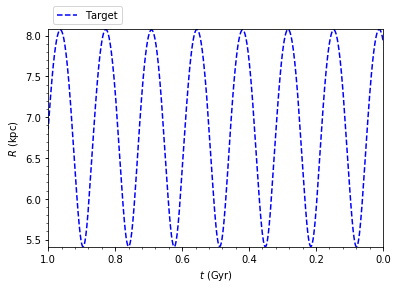

In [14]:
target_orbit.plot(d1='t', d2='R', color='b', linestyle='--', label='Target')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);
plt.gca().invert_xaxis()

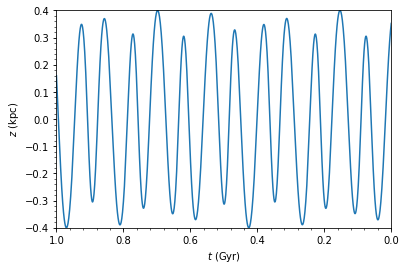

In [15]:
target_orbit.plot(d1='t', d2='z')
plt.gca().invert_xaxis()

In [16]:
target_orbit.z?